# Example of discrete hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

Consider the European call options that at time $T$ pays $X = (S(T) - K)^+$ where $K > 0$ is the strike price.

Chope the time interval between now (time 0) and expiry of the call-option (time $T$) into $N$ pieces; denote the discretization points $t_i$.  

In [1]:
import numpy as np

import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.gbm import UnivGeometricBrownianMotion
from jaxfin.price_engine.black_scholes import european_price, delta_european

In [2]:
seed = 0
np.random.seed(seed)

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.05 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [3]:
s0 = 100
sigma = 0.2
mean = 0.00

params = {
    's0' : s0,
    'dtype' : jnp.float32,
    'mean' : mean,
    'sigma': sigma
}
gmb = UnivGeometricBrownianMotion(**params)

In [4]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 1

stock_path = gmb.sample_paths(maturity, N, n_sim)

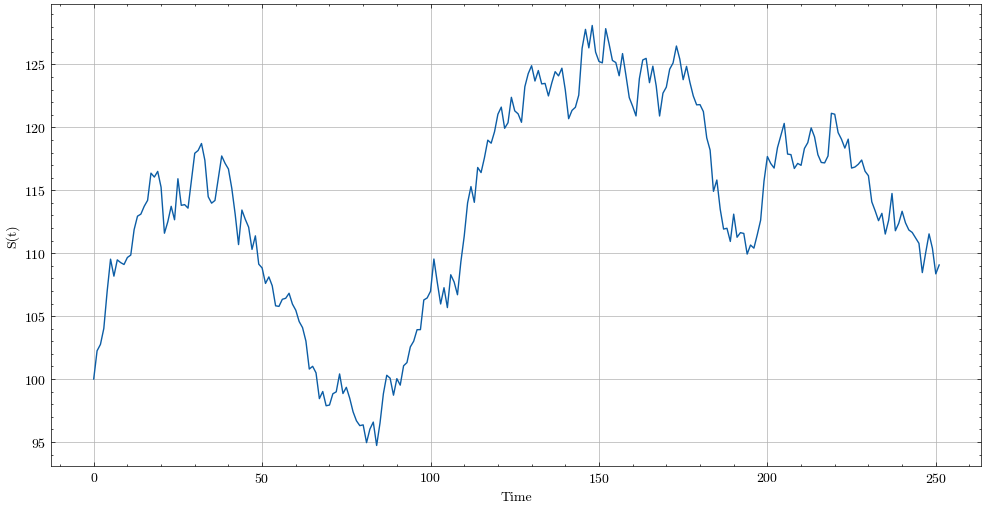

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(stock_path)
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [6]:
K = 110
discount_rate = 0.0
dividends = 0.0

In [7]:
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))

In [8]:
deltas = [v_delta_european(stock_path[i], K, maturity - i * dt, sigma, discount_rate) for i in range(0, N)]
cs = [european_price(stock_path[i], K, maturity - i * dt, sigma, discount_rate) for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_path[0]]
vs = [cs[0]]

for i in range(1, N):
    vs.append(deltas[i - 1] * stock_path[i] + b[i - 1])
    b.append(vs[i] - deltas[i] * stock_path[i])
    
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path - K, 0)

In [9]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  [0.4003563]


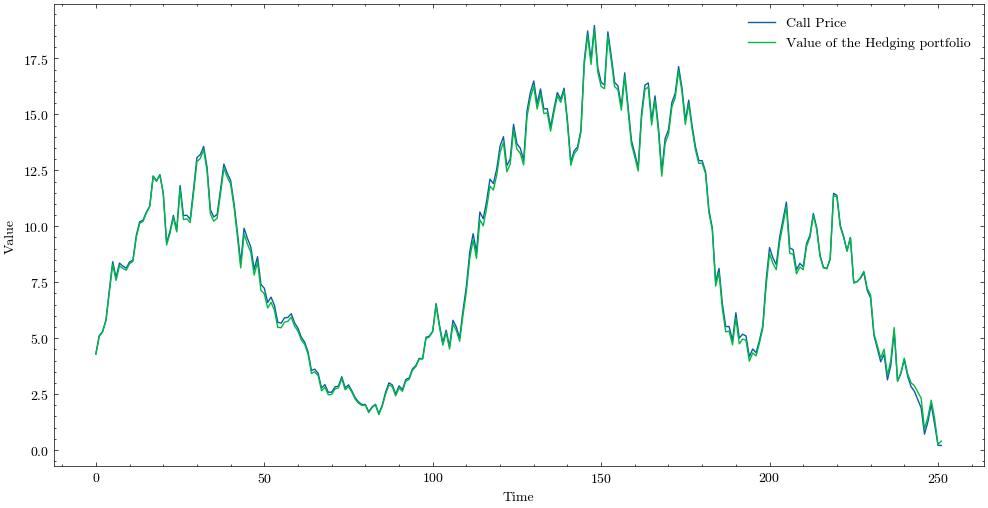

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(cs, label='Call Price')
plt.plot(vs, label='Value of the Hedging portfolio')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## With low transactions costs

In [12]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [21]:
deltas = [v_delta_european(stock_path[i], K, maturity - i * dt, sigma, discount_rate) for i in range(0, N)]
cs = [european_price(stock_path[i], K, maturity - i * dt, sigma, discount_rate) for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_path[0]]
vs = [cs[0]]

for i in range(1, N):
    ddelta = deltas[i] - deltas[i - 1]
    transaction_costs = get_transaction_costs(0.01, ddelta)

    vs.append(deltas[i - 1] * stock_path[i] + b[i - 1])
    b.append(vs[i] - (deltas[i] + transaction_costs) * stock_path[i])
    
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path - K, 0)

[0.00041595]
[9.261065e-05]
[0.00023693]
[0.00055939]
[0.00047041]
[0.00025092]
[0.00023885]
[4.1171217e-05]
[2.9065857e-05]
[0.00010229]
[3.4328088e-05]
[0.00036852]
[0.00019051]
[2.9323364e-05]
[0.00011016]
[8.2374434e-05]
[0.00036635]
[4.9750295e-05]
[7.591287e-05]
[0.0002091]
[0.00064884]
[0.00016701]
[0.00021993]
[0.00019124]
[0.00057379]
[0.00036648]
[1.0824321e-05]
[4.8965823e-05]
[0.00038866]
[0.00036077]
[3.79541e-05]
[9.109433e-05]
[0.00021312]
[0.00049825]
[9.0751535e-05]
[3.9933722e-05]
[0.00031568]
[0.00030041]
[9.5024785e-05]
[7.5146236e-05]
[0.00026779]
[0.00037479]
[0.00046402]
[0.00052737]
[0.00013822]
[0.00012046]
[0.00034683]
[0.00021283]
[0.00045146]
[6.276882e-05]
[0.00025525]
[0.00010523]
[0.00014806]
[0.00033747]
[1.2793705e-05]
[0.0001163]
[1.42653835e-05]
[8.1671584e-05]
[0.00018562]
[0.00010832]
[0.00019621]
[0.00010728]
[0.00023393]
[0.00047774]
[4.0031784e-05]
[0.00011478]
[0.00042912]
[0.00010881]
[0.00023617]
[4.23463e-06]
[0.00017472]
[2.4632822e-05]
[0.0

In [22]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  [-8.13792]


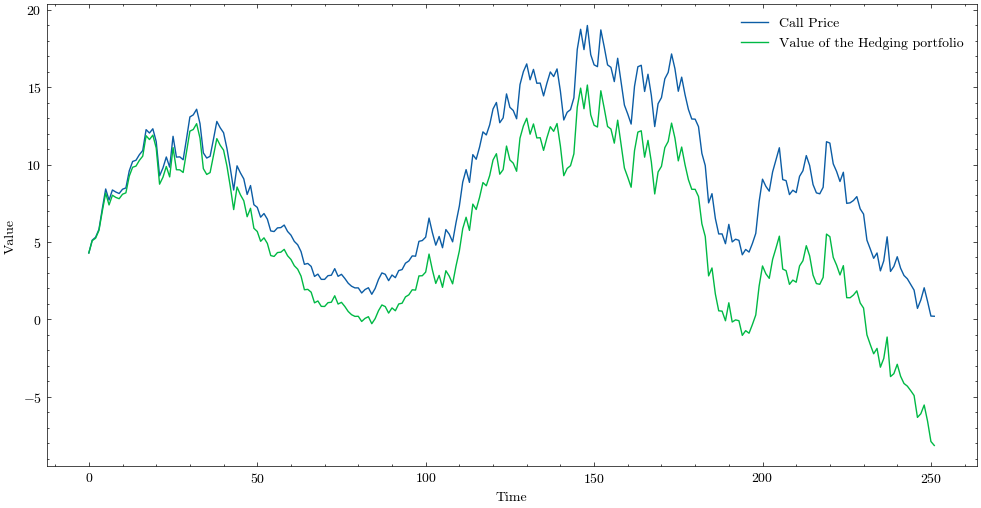

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(cs, label='Call Price')
plt.plot(vs, label='Value of the Hedging portfolio')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()